In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
from tqdm import tqdm
import numpy as np
import cv2
import open3d as o3d
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
from Hydranet import Hydranet

In [2]:
hydranet = Hydranet(2, 6)
ckpt = torch.load("ExpKITTI_joint.ckpt", map_location='cpu')
hydranet.enc.load_state_dict(ckpt["state_dict"], strict=False)
hydranet.dec.load_state_dict(ckpt["state_dict"], strict=False)
hydranet.eval()

Hydranet(
  (enc): Mobilenet_backbone(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (layer2): Sequential(
      (0): InvertedResidualBlock(
        (output): Sequential(
          (0): Sequential(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (2): Sequential(
            (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias

In [3]:
IMG_SCALE  = 1./255
IMG_MEAN = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
IMG_STD = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))
CMAP = np.load('cmap_kitti.npy')
NUM_CLASSES = 6

In [4]:
def prepare_img(img):
    return (img * IMG_SCALE - IMG_MEAN) / IMG_STD


def pipeline(img):
    with torch.no_grad():
        img_var = Variable(torch.from_numpy(prepare_img(img).transpose(2,0,1)[None]), requires_grad=False).float()
        # if torch.cuda.is_available():
        #     img_var = img_var.cuda()
        depth, segm = hydranet(img_var)
        segm = cv2.resize(segm[0].cpu().data.numpy().transpose(1,2,0), img.shape[:2][::-1], interpolation=cv2.INTER_CUBIC)
        depth = cv2.resize(depth[0].cpu().data.numpy().transpose(1,2,0), img.shape[:2][::-1], interpolation=cv2.INTER_CUBIC)
        segm = CMAP[segm.argmax(axis=2)].astype(np.uint8)
        depth = np.abs(depth).astype(np.uint8)
        return depth, segm

In [9]:
images_files = glob.glob('data/*.png')
len(images_files)

110

In [24]:
def plot_inference(images_files, idx):
    img_path = images_files[idx]
    img = np.array(Image.open(img_path))
    depth, segm = pipeline(img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))
    ax1.imshow(img)
    ax1.set_title('Original', fontsize=30)
    ax2.imshow(segm)
    ax2.set_title('Predicted Segmentation', fontsize=30)
    ax3.imshow(depth, cmap="viridis", vmin=0, vmax=40)
    ax3.set_title("Predicted Depth", fontsize=30)
    plt.show()

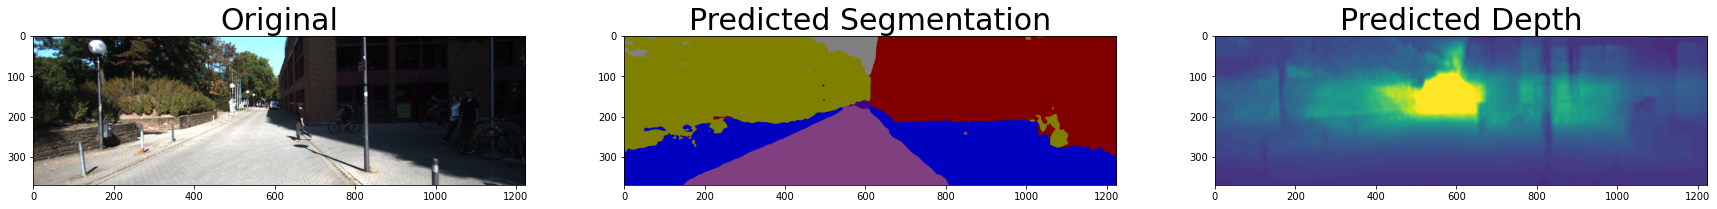

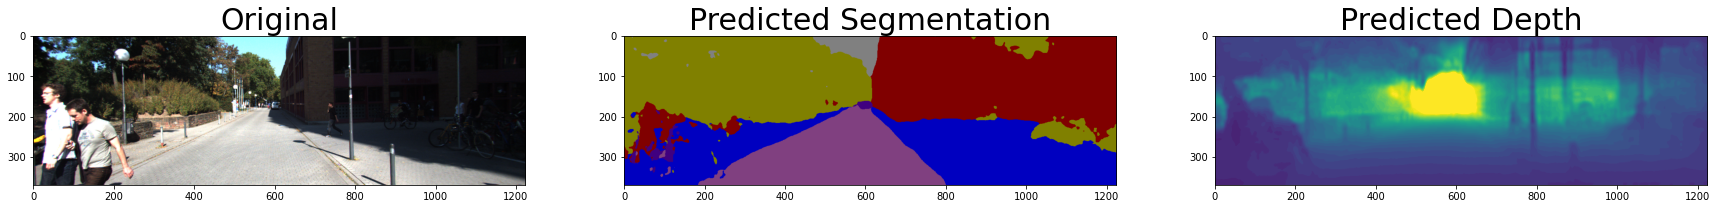

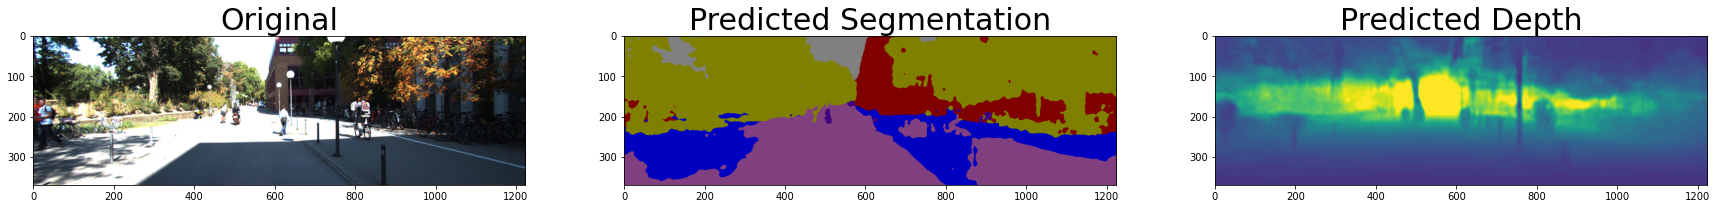

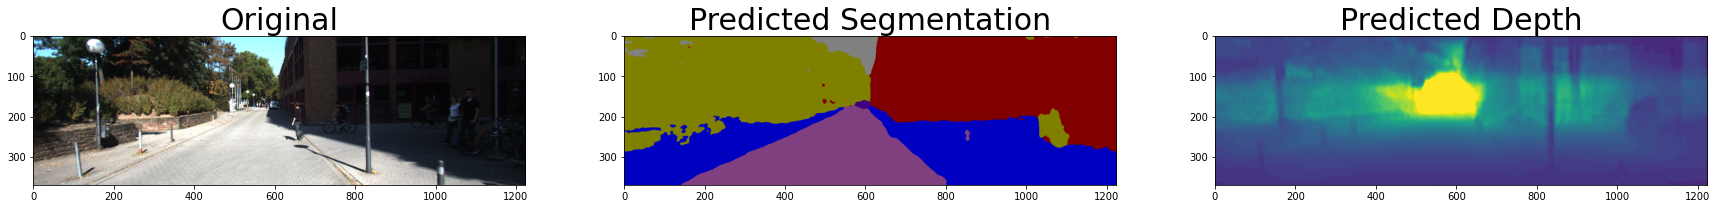

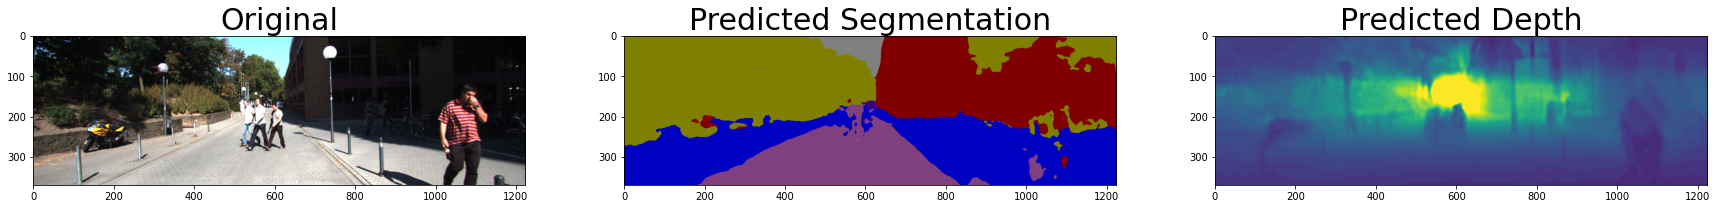

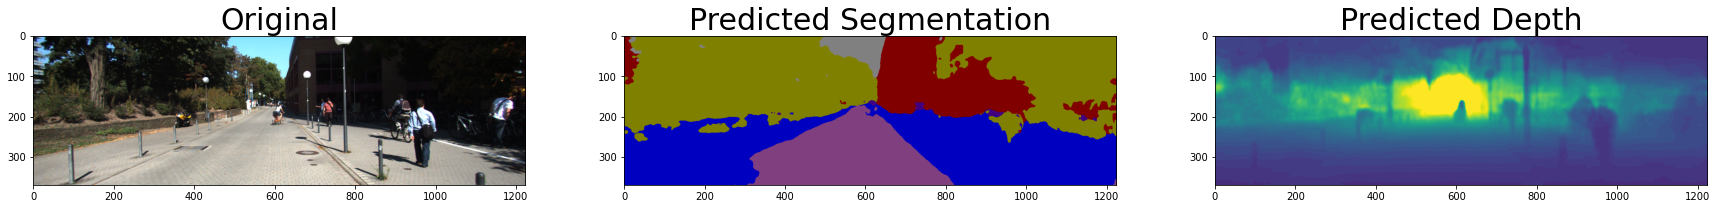

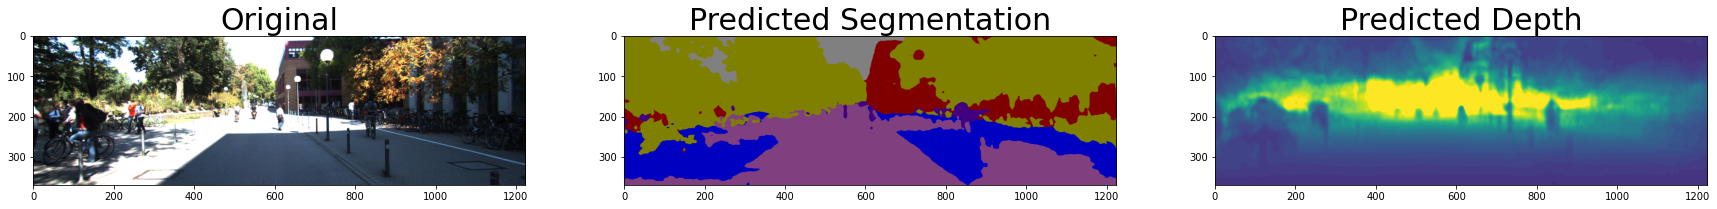

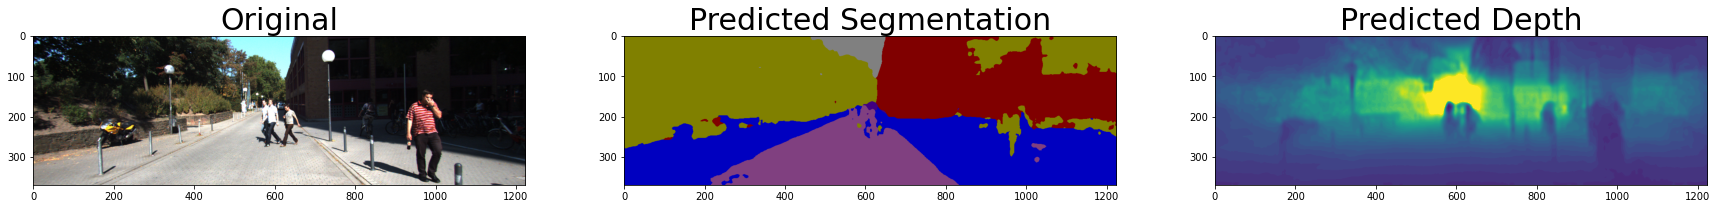

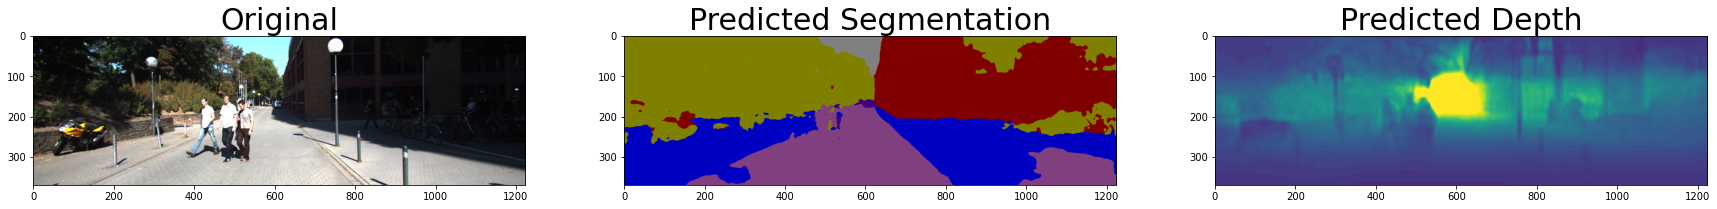

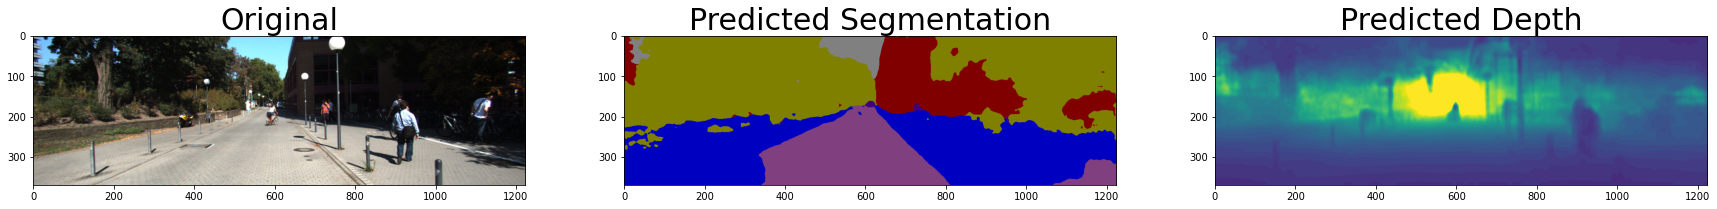

In [25]:
for i in range(10):
    plot_inference(images_files, i)

In [19]:
def infer(image_file):
    img = np.array(Image.open(image_file))
    depth, segm = pipeline(img)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(segm), o3d.geometry.Image(depth), convert_rgb_to_intensity=False)
    intrinsics = o3d.camera.PinholeCameraIntrinsic(width = 1242, height = 375, fx = 721., fy = 721., cx = 609., cy = 609.)
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd,intrinsics)
    point_cloud.transform([[1,0,0,0], [0,-1,0,0], [0,0,-1,0],[0,0,0,1]])
    pc_with_image = np.concatenate([np.asarray(point_cloud.points) * 1e5, img.reshape(-1, 3)], axis=-1)
    pc_with_segm = np.concatenate([np.asarray(point_cloud.points) * 1e5, segm.reshape(-1, 3)], axis=-1)
    return img, segm, depth, pc_with_image, pc_with_segm

In [17]:
import wandb

wandb.login()
wandb.init(project="Multi-Task-Learning", entity="hydranet")

ERROR - 2022-01-26 15:25:03,979 - jupyter - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: geekyrakshit (use `wandb login --relogin` to force relogin)


In [21]:
table_data = []
for i in tqdm(range(10)):
    img, segm, depth, pc_with_image, pc_with_segm = infer(images_files[i])
    table_data.append([
        wandb.Image(img),
        wandb.Image(segm),
        wandb.Image(depth),
        wandb.Object3D({
            "type": "lidar/beta",
            "points": pc_with_image
        }),
        wandb.Object3D({
            "type": "lidar/beta",
            "points": pc_with_segm
        })
    ])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.45s/it]


In [22]:
table = wandb.Table(
    data=table_data,
    columns=[
        "Image", "Segmentation Mask", "DepthMap", "Point Cloud with Image", "Point Cloud with Mask"
    ]
)

wandb.log({"KITTI-Inference": table})

In [7]:
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(segm), o3d.geometry.Image(depth), convert_rgb_to_intensity=False)
intrinsics = o3d.camera.PinholeCameraIntrinsic(width = 1242, height = 375, fx = 721., fy = 721., cx = 609., cy = 609.)
point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd,intrinsics)

In [8]:
point_cloud.transform([[1,0,0,0], [0,-1,0,0], [0,0,-1,0],[0,0,0,1]])

PointCloud with 452880 points.

In [10]:
final_pc = np.concatenate([np.asarray(point_cloud.points) * 1e5, segm.reshape(-1, 3)], axis=-1)
final_pc.shape

(452880, 6)

In [11]:
point_scene = wandb.Object3D({
    "type": "lidar/beta",
    "points": final_pc
})

wandb.log({"point_cloud": point_scene})

In [23]:
wandb.finish()